In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import re


from bids import BIDSLayout

from sklearn.model_selection import cross_val_score, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder

from util.decoding.gee import GEEEstimator
from mne_ari import all_resolutions_inference
from mne.decoding import (
    cross_val_multiscore, 
    LinearModel,                  
    SlidingEstimator, 
    get_coef
)
from mne import set_config
set_config('MNE_MEMMAP_MIN_SIZE', '1M')
set_config('MNE_CACHE_DIR', '.tmp')
import mne

In [2]:
# hard-coded values
BIDS_ROOT = 'bids'
DERIV_ROOT = os.path.join(BIDS_ROOT, 'derivatives')

In [3]:
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
subjects = layout.get_subjects(scope = 'preprocessing')
subjects.sort()
task = layout.get_tasks()[0]

/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


In [4]:
def load_subj_data(layout, sub):
    
    epochs_fpath = layout.get(
        scope = 'preprocessing', 
        subject = sub, 
        desc = 'clean', 
        extension = 'fif.gz', 
        return_type = 'filename')[0]
    epochs = mne.read_epochs(epochs_fpath, preload = True, verbose = False)
    downsample_fs = 2 * epochs.info['lowpass']
    
    epochs.resample(downsample_fs)
    epochs = epochs.crop(-.1, .7)
    
    events_fpath = layout.get(
        scope = 'raw', 
        subject = sub, 
        suffix = 'events', 
        extension = 'tsv', 
        return_type = 'filename')[0]
    events_df = pd.read_csv(events_fpath, sep = '\t')
    funded = events_df.funded[epochs.selection].to_numpy()
    choice = events_df.choice[epochs.selection].to_numpy()
    stims = events_df.project_id[epochs.selection].to_numpy()
    
    X = epochs.get_data()
    
    return epochs, X, funded, choice, stims

In [5]:
all_X = []
all_fund = []
all_choice = []
all_stims = []
all_subs = []
evs = []

for sub in subjects:
    
    if sub in ['110', '114']: # no visible P1 compenent 
        continue
    
    epochs, X, funded, choice, stims = load_subj_data(layout, sub)
    all_X.append(X)
    all_fund.append(funded)
    all_choice.append(choice)
    all_stims.append(stims)
    all_subs.append(np.repeat(sub, funded.shape[0]))
    evs.append(epochs.average())
    
X = np.concatenate(all_X)
funded = np.concatenate(all_fund)
choice = np.concatenate(all_choice)
stims = np.concatenate(all_stims)
stims = LabelEncoder().fit_transform(stims)
subs = np.concatenate(all_subs)
subs = LabelEncoder().fit_transform(subs)

# Main Analysis
## Decoding Individual and Aggregate Choice Behavior

In [6]:
# define classification pipeline
logistic_reg = GEEEstimator(family = 'binomial', cov_type = 'naive')
clf = LinearModel(logistic_reg)
time_decod = SlidingEstimator(clf, n_jobs = 5, scoring = 'roc_auc', verbose = True)

# trials for which subjects actually made a choice (didn't time out)
idx = np.isfinite(choice)

# cross-validate 
optim_params = dict(maxiter = 100, first_dep_update = 20, params_niter = 10)
i = 0
indiv_choice_scores = []
while len(indiv_choice_scores) < 10:
    try:
        scr = cross_val_multiscore(
            time_decod, 
            X[idx,...], choice[idx], stims[idx],
            fit_params = dict(
                groups = subs[idx],
                **optim_params
            ),
            n_jobs = 1,
            cv = StratifiedGroupKFold(2, shuffle = True, random_state = i) 
        )
        indiv_choice_scores.append(scr)
    except: # if bad split (overflow in link function's `exp`), 
        i += 1 # then try another

  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.0s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.0s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.0s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.0s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.0s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    5.7s remaining:    3.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.2s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s finished


In [7]:
def ttest_1samp_kx2cv(scores, chance = 0.5):
    '''
    Input: list of k (2, n_tests) arrays of scores obtained from
            a series of k different 2-fold cross validation splits
            
    Output: t-values, p-values, and standard errors from 
            a kx2 t-test for classification metrics with null
            hypothesis that metric == 0.5. These are all
            (n_tests,) arrays. Test described in [1].
            
    References
    ----------
    [1] Dietterich TG (1998) Approximate Statistical Tests for 
        Comparing Supervised Classification Learning Algorithms.
        Neural Comput 10:1895–1923.
    '''
    from scipy.stats import t as t_dist
    above_chance = [(scrs - chance) for scrs in scores]
    if above_chance[0].ndim == 1:
        above_chance = [ac[:, np.newaxis] for ac in above_chance]
    # estimate standard error from all the splits
    s2 = [np.square(scrs - scrs.mean(0)).sum(0) for scrs in above_chance]
    s2 = np.stack(s2, axis = 0)
    # but only use first split for observed value since scores on CV splits
    p1 = above_chance[0][0, :] # are not truly independent of one another.
    se = np.sqrt(s2.mean(0)) # see [1]
    # after that, it's just a normal t-test
    t = p1 / se
    p = t_dist.sf(t, df = s2.shape[0]) # one-sided p-value 
    return t, p, (p1 + chance), se

/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/mne_ari/ari/parametric.py:60: UserWarning: 
Parametric ARI assumes that the p-values of individual tests are valid when
calculating the true positive proprtion. If this isn't likely true (e.g. 
you're using a parametric test on M/EEG data), you may want to consider using
permutation-based ARI instead.

  warnings.warn(
/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/mne_ari/ari/parametric.py:60: UserWarning: 
Parametric ARI assumes that the p-values of individual tests are valid when
calculating the true positive proprtion. If this isn't likely true (e.g. 
you're using a parametric test on M/EEG data), you may want to consider using
permutation-based ARI instead.

  warnings.warn(


Cluster 1: 110 to 110 ms, observed score = 0.527, p <= 6.438523733916825e-06
Cluster 2: 180 to 180 ms, observed score = 0.529, p <= 1.0558230003216274e-06
Cluster 3: 260 to 280 ms, observed score = 0.548, p <= 0.0003443934345067012
Cluster 4: 310 to 320 ms, observed score = 0.549, p <= 9.96628439945287e-07
Cluster 5: 340 to 350 ms, observed score = 0.541, p <= 3.1265595925107374e-06
Cluster 6: 380 to 400 ms, observed score = 0.565, p <= 0.0002213931963374587
Cluster 7: 420 to 420 ms, observed score = 0.574, p <= 2.0632374261872242e-11
Cluster 8: 440 to 440 ms, observed score = 0.561, p <= 4.112966677298502e-07
Cluster 9: 460 to 480 ms, observed score = 0.584, p <= 1.241542825251849e-07
Cluster 10: 510 to 510 ms, observed score = 0.575, p <= 2.7381668314693067e-10
Cluster 11: 540 to 550 ms, observed score = 0.570, p <= 2.9828798861944477e-09
Cluster 12: 580 to 610 ms, observed score = 0.570, p <= 0.00046355021357607953
Cluster 13: 660 to 660 ms, observed score = 0.578, p <= 0.0003695053

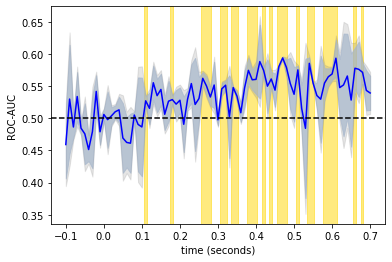

In [8]:
def summarize_results(scores, alpha, metric_name = 'ROC-AUC'):
    
    from mne.stats.cluster_level import _find_clusters
    from scipy.stats import norm
    
    # compare to chance at every time point
    _, p, obs_scores, se = ttest_1samp_kx2cv(scores)
    # and correct for multiple comparisons 
    _, tdp, clusters = all_resolutions_inference(
        p[np.newaxis, :], alpha, 
        statfun = lambda x: np.squeeze(x), 
        ari_type = 'parametric',
        thresholds = 'all'
        )
    
    # get z-cutoff for post-selection confidence intervals
    # with false-coverage rate correction as
    # described by Rosenblatt & Benjamani (2014)
    n_rejected = np.sum(tdp >= 1 - alpha)
    n_tests = p.size
    alpha_adjusted = alpha * (n_rejected / n_tests)
    z = norm.ppf(1 - alpha/2)
    z_corrected = norm.ppf(1 - alpha_adjusted/2)
    
    # and plot
    fig, ax = plt.subplots()
    ax.plot(epochs.times, obs_scores, color = 'blue')
    ax.axhline(.5, color = 'black', linestyle = '--')
    upper = obs_scores + z*se
    lower = obs_scores - z*se
    ax.fill_between(epochs.times, upper, lower, color = 'lightsteelblue', alpha = .7)
    upper = obs_scores + z_corrected*se
    lower = obs_scores - z_corrected*se
    ax.fill_between(epochs.times, upper, lower, color = 'gray', alpha = .2)
    ax.set_xlabel('time (seconds)')
    ax.set_ylabel(metric_name)
    
    fs = epochs.info['sfreq']
    
    t = []
    
    identity_statfun = lambda x: np.squeeze(x)
    _, _, clusters = all_resolutions_inference(
        p[np.newaxis, :], alpha, 
        statfun = identity_statfun, 
        ari_type = 'parametric'
        )
    
    for i, clust in enumerate(clusters):
        times = epochs.times[clust]
        t_start = min(times)
        t_end = max(times)
        t.append((t_start + t_end)/2)
        ax.axvspan(t_start - .5/fs, t_end + .25/fs, 
                   alpha = .5, color = 'gold', zorder = 0)
        scr = obs_scores[clust].mean() # average within cluster 
        print(
            'Cluster {:d}: {:.0f} to {:.0f} ms, observed score = {:.3f},'.format(
                i + 1, 1e3*t_start, 1e3*t_end, scr
            ) + ' p <= ' + str(p[clust].max())
        )
    return fig, ax, t, clusters

fig, ax, t_indiv, clusts_indiv = summarize_results(indiv_choice_scores, alpha = .05)
plt.show()

In [9]:
cv_methds = [StratifiedGroupKFold(2, shuffle = True, random_state = i) for i in range(10)]
funding_scores = [cross_val_multiscore(
    time_decod, 
    X, funded, stims,
    fit_params = dict(groups = subs),
    n_jobs = 1,
    cv = cv) for cv in cv_methds
]

  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.6s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1251: IterationLimitWarning: Iteration limit reached prior to convergence
  warnings.warn("Iteration limit reached prior to convergence",
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1251: IterationLimitWarning: Iteration limit reached prior to convergence
  warnings.warn("Iteration limit reached prior to convergence",
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.1s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.0s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.9s finished


  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1251: IterationLimitWarning: Iteration limit reached prior to convergence
  warnings.warn("Iteration limit reached prior to convergence",
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.8s finished


/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/mne_ari/ari/parametric.py:60: UserWarning: 
Parametric ARI assumes that the p-values of individual tests are valid when
calculating the true positive proprtion. If this isn't likely true (e.g. 
you're using a parametric test on M/EEG data), you may want to consider using
permutation-based ARI instead.

  warnings.warn(
/home/johnv/anaconda3/envs/neuroforecasting/lib/python3.9/site-packages/mne_ari/ari/parametric.py:60: UserWarning: 
Parametric ARI assumes that the p-values of individual tests are valid when
calculating the true positive proprtion. If this isn't likely true (e.g. 
you're using a parametric test on M/EEG data), you may want to consider using
permutation-based ARI instead.

  warnings.warn(


Cluster 1: 210 to 210 ms, observed score = 0.543, p <= 0.00042627564521672303
Cluster 2: 230 to 230 ms, observed score = 0.552, p <= 0.00013379624858835166
Cluster 3: 420 to 420 ms, observed score = 0.537, p <= 0.0005894007122039735


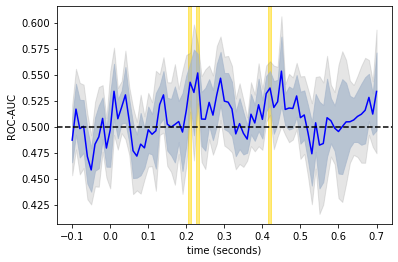

In [10]:
fig, ax, t_funded, clusts_funding = summarize_results(funding_scores, alpha = .05)
plt.show()

In [11]:
time_decod.fit(X[idx,...], choice[idx], groups = subs[idx])
coef = get_coef(time_decod, 'patterns_')
indiv_patterns = mne.EvokedArray(coef, epochs.info, tmin = epochs.times[0])
indiv_patterns.nave = None

  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

No projector specified for this dataset. Please consider the method self.add_proj.


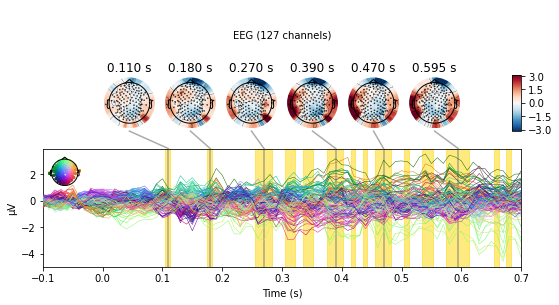

In [12]:
fig = indiv_patterns.plot_joint(t_indiv[:2] + t_indiv[2::3], show = False)
ax = fig.axes[0] # axis for butterfly plot
for i, clust in enumerate(clusts_indiv):
    times = epochs.times[clust]
    t_start = min(times)
    t_end = max(times)
    ax.axvspan(t_start - .5/epochs.info['sfreq'], t_end + .25/epochs.info['sfreq'], 
                alpha = .5, color = 'gold', zorder = 0)
plt.show()

In [13]:
time_decod.fit(X, funded, groups = subs)
coef = get_coef(time_decod, 'patterns_')
funding_patterns = mne.EvokedArray(coef, epochs.info, tmin = epochs.times[0])
funding_patterns.nave = None

  0%|          | Fitting SlidingEstimator : 0/81 [00:00<?,       ?it/s]

No projector specified for this dataset. Please consider the method self.add_proj.


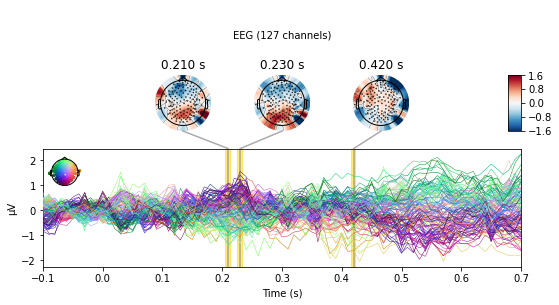

In [14]:
fig = funding_patterns.plot_joint(t_funded, show = False)
ax = fig.axes[0] # axis for butterfly plot
for i, clust in enumerate(clusts_funding):
    times = epochs.times[clust]
    t_start = min(times)
    t_end = max(times)
    ax.axvspan(t_start - .5/epochs.info['sfreq'], t_end + .25/epochs.info['sfreq'], 
                alpha = .5, color = 'gold', zorder = 0)
plt.show()

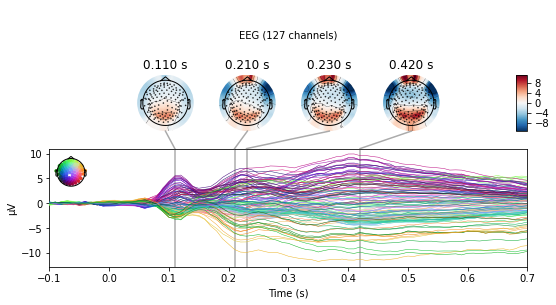

In [15]:
# plot grand average ERP
evoked = mne.combine_evoked(evs, weights = 'equal')
evoked.nave = None
fig = evoked.plot_joint([t_indiv[0]] + t_funded, show = False)
plt.show()

# Can individual choice behavior explain decoding of aggregate?

In [16]:
cv_methds = [StratifiedGroupKFold(2, shuffle = True, random_state = i) for i in range(10)]
fit_params = dict(groups = subs[idx], maxiter = 500, params_niter = 5)
scores = [
    cross_val_score(
        logistic_reg,
        choice[idx], funded[idx], # predict funding from individual choices
        groups = stims[idx],
        fit_params = fit_params,
        scoring = 'roc_auc',
        cv = cv) for cv in cv_methds
]

# test against null hpyothesis that AUC == 0.5
t, p, m, se = ttest_1samp_kx2cv(scores)
print('ROC-AUC is {:.2f} +/- {:.2f} ----> t({:d}) = {:.2f}, p = {:.2f}'.format(
    m[0], 1.96*se[0], len(scores), t[0], p[0]
    )
)

ROC-AUC is 0.50 +/- 0.05 ----> t(10) = 0.17, p = 0.44


Even with access to perfect information on individual choice (and our EEG-based classifier obviously has imperfect information), we can't use it to obtain significantly above-chance performance when predicting individual choice. Obviously, for very large samples, this would not be the case since average individual behavior and group behavior are practically the same thing for sufficiently large _n_. But the idea is that a correlation between group and individual choice behavior can't (on its own) explain the performance of our current classifier.

We can also do a more traditional regression analysis (without cross-validation), since our classifier is ultimately just a generalized linear model.

In [17]:
logistic_reg.fit(
    choice[idx], funded[idx], 
    **fit_params
)
print(logistic_reg.summary())

                               GEE Regression Results                              
Dep. Variable:                           y   No. Observations:                 1182
Model:                                 GEE   No. clusters:                       16
Method:                        Generalized   Min. cluster size:                  34
                      Estimating Equations   Max. cluster size:                  91
Family:                           Binomial   Mean cluster size:                73.9
Dependence structure:         Exchangeable   Num. iterations:                     6
Date:                     Sat, 12 Feb 2022   Scale:                           1.000
Covariance type:                     naive   Time:                         19:18:08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0165      0.034     -0.489      0.625      -0.083       0.050
x1     

Let's visualize how consistent choices were across our subjects.

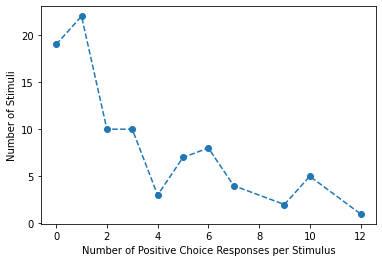

In [18]:
choices = pd.DataFrame({'choice': choice[idx], 'stimulus': stims[idx]})
n_picked_per_stim = choices.groupby('stimulus').sum().to_numpy()
n_picked_per_stim = np.squeeze(n_picked_per_stim)
n_picks, n_projs = np.unique(n_picked_per_stim, return_counts = True)
plt.plot(n_picks, n_projs, linestyle = '--', marker = 'o')
plt.xlabel('Number of Positive Choice Responses per Stimulus')
plt.ylabel('Number of Stimuli')
plt.show()

# Exploratory Analysis
## Interrogating the models that predict aggregate choice

Since we fit a GLM across all subjects using generalized estimating equations (for partial pooling across subjects) instead of a single model per subject (or any model with an explicit regularization penalty), we're able to use all of the inference methods afforded by GEE-fit linear models. Of course, we're picking only models that had above-chance cross-validation accuracy, so we'll experience a post-selection bias. That is, this analysis should not be taken as confirmatory of, say, parietal involvement in decision-making. All these tests are doing is "asking" the fitted classifiers whether hand-picked groups of electrodes were important to _to the model_; they should be taken as explaining the _models themsleves,_ __not__ explaining the EEG data directly.

In [19]:
# extract estimators that predict aggregate choice above chance
estimators = []
t_estimators = []
for clust in clusts_funding:
    est = time_decod.estimators_[clust]
    estimators.append(est)
    t_estimators.append(epochs.times[clust])
estimators = np.concatenate(estimators)
estimators = np.array([est.model for est in estimators])
t_estimators = np.concatenate(t_estimators)

In [20]:
hcgsn_1020_positions = {
    #
    # these equivalances are from 
    #
    # Luu, P., & Ferree, T. (2005). Determination of the 
    # HydroCel Geodesic Sensor Nets’ average electrode positions
    # and their 10–10 international equivalents.
    # Inc, Technical Note, 1-11.
    #
    'C3': 'E36',
    'C4': 'E104',
    'Cz': 'Cz',
    'F3': 'E24',
    'F4': 'E124',
    'F7': 'E33',
    'F8': 'E122',
    'FP1': 'E22',
    'FPz': 'E14',
    'Fz': 'E11',
    'O1': 'E70',
    'O2': 'E83',
    'P3': 'E52',
    'P4': 'E92',
    'T5': 'E58', # some electrodes are borderline between
    'P7': 'E58', # temporal and parietal so they're listed
    'T6': 'E96', # under both names
    'P8': 'E96',
    'T3-T7': 'E45',
    'T4-T8': 'E108',
    'AF3': 'E23',
    'AF4': 'E3',
    'AF7': 'E26',
    'AF8': 'E2',
    'AFz': 'E16',
    'C1': 'E30',
    'C2': 'E105',
    'C5': 'E41',
    'C6': 'E103',
    'CP1': 'E37',
    'CP2': 'E87',
    'CP3': 'E42',
    'CP4': 'E93',
    'CP5': 'E47',
    'CP6': 'E98',
    'CPz': 'E55',
    'F1': 'E19',
    'F10': 'E1'
}

def get_channel_names(area):
    a = '%s(\d+|z)'%area
    pos = [p for p in hcgsn_1020_positions if len(re.findall(a, p)) > 0]
    pos = [p for p in pos if p[:len(area)] == area]
    return [hcgsn_1020_positions[p] for p in pos]

def get_region_mask(area):
    '''
    Given a 10-20 region code (e.g. 'F'), this function will return a
    boolean mask to select that region.
    '''
    if area == 'F': # AF is between F and FP
        chs = get_channel_names('F') + get_channel_names('AF')
    elif area == 'P': # CP is between P and C
        chs = get_channel_names('P') + get_channel_names('CP')
    else:
        chs = get_channel_names(area)
    return np.isin(epochs.ch_names, chs)

In [21]:
areas = ['FP', 'F', 'T', 'C', 'P', 'O']
for est, t in zip(estimators, t_estimators):
    for area in areas:
        mask = get_region_mask(area)
        w, p = est.wald_test(mask)
        if p < .05:
            print('%s elecrodes are important at %d ms, p = '%(area, t*1e3) + str(p))

FP elecrodes are important at 209 ms, p = 0.006925486081984607
P elecrodes are important at 229 ms, p = 0.03654010767009713
FP elecrodes are important at 420 ms, p = 0.03819220133824491
C elecrodes are important at 420 ms, p = 0.025618730406750292
